In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import requests
import json
import prettytable

In [3]:
#adapted from https://www.bls.gov/developers/api_python.htm

def get_CPI_U(startYear, EndYear):
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid": ['CUUR0000SA0'],"startyear":str(startYear), "endyear":str(EndYear)})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)

    cpiData = pd.DataFrame(json_data['Results']['series'][0]['data'])
    cpiData['period'] = cpiData['period'].str.replace(r'^M0|^M', '', regex=True)

    return cpiData[["year","period","value"]]


In [4]:
cpi1 = get_CPI_U(2004,2014)
cpi2 = get_CPI_U(2014,2024)
cpi1


,year,period,value
0,2013,12,233.049
1,2013,11,233.069
2,2013,10,233.546
3,2013,9,234.149
4,2013,8,233.877
...,...,...,...
115,2004,5,189.1
116,2004,4,188.0
117,2004,3,187.4
118,2004,2,186.2


In [5]:

cpiData= pd.concat([cpi1,cpi2], ignore_index=True)
cpiData.sort_values(by=['year', 'period'])


,year,period,value
119,2004,1,185.2
110,2004,10,190.9
109,2004,11,191.0
108,2004,12,190.3
118,2004,2,186.2
...,...,...,...
127,2023,5,304.127
126,2023,6,305.109
125,2023,7,305.691
124,2023,8,307.026


In [6]:

cpiData['value'] = cpiData['value'].astype(float)
cpiData['year'] = cpiData['year'].astype(int)
cpiData['period'] = cpiData['period'].astype(int)
min_val = cpiData['value'].min()
baseVal = cpiData[cpiData["year"] == cpiData['year'].max()]
baseVal = baseVal[baseVal["period"] == baseVal['period'].max()]['value']
print(baseVal)
cpiData['scale'] =  baseVal.iloc[0] / cpiData['value'] 
cpiData =cpiData.sort_values(by=['year', 'period'])
cpiData

120    306.746
Name: value, dtype: float64


,year,period,value,scale
119,2004,1,185.200,1.656296
118,2004,2,186.200,1.647401
117,2004,3,187.400,1.636852
116,2004,4,188.000,1.631628
115,2004,5,189.100,1.622136
...,...,...,...,...
124,2023,8,307.026,0.999088
123,2023,9,307.789,0.996611
122,2023,10,307.671,0.996994
121,2023,11,307.051,0.999007


In [7]:
#stole from Michael

# Set the font size for titles
plt.rcParams['axes.titlesize'] = 20

# Set the font size for labels on the x-axis and y-axis
plt.rcParams['axes.labelsize'] = 16

# Set the font size for ticks on the x-axis and y-axis
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Set the width of lines in plots
plt.rcParams['lines.linewidth'] = 2.0

# Set the default figure size
plt.rcParams['figure.figsize'] = (12, 6)

# Set the default style to use
plt.style.use('ggplot')

# Set the default savefig format
plt.rcParams['savefig.format'] = 'png'

# Set the default style
sns.set_style("darkgrid")

# Set the default palette
sns.set_palette("deep")

# Set the default context
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})


In [8]:
#import combined_data
filename = '../../data/combined_data.csv'

df = pd.read_csv(filename)



df_inflation = (pd.merge(df, cpiData[['scale', 'year', 'period']], left_on=['YearNum', 'MonthNum'], right_on=['year', 'period'], how='left')).drop(columns=["period", "year"])
df_inflation = df_inflation.dropna(subset=['scale'])
df_inflation['inflationAdjusted'] = df_inflation['scale'] * df_inflation["AvgPrice"]

df = df_inflation
df

,Sold,AvgPrice,YearNum,MonthNum,FishGroup,Country,scale,inflationAdjusted
0,2385.445111,6.900461,2023,1,Cod,USA,1.025323,7.075204
1,215.003039,3.703762,2023,1,Haddock,USA,1.025323,3.797553
2,32.658689,3.924224,2023,1,Cod,USA,1.025323,4.023598
3,5855.430868,5.114718,2023,1,Haddock,USA,1.025323,5.244240
4,1518.629061,5.555642,2023,1,Hake,USA,1.025323,5.696330
...,...,...,...,...,...,...,...,...
5652,49532.000000,7.301744,2013,8,Haddock,UNITED KINGDOM,1.311570,9.576747
5653,158618.000000,2.314870,2020,5,Cod,GERMANY,1.196385,2.769476
5654,158618.000000,2.314870,2020,6,Cod,GERMANY,1.189874,2.754404
5655,33715.000000,4.629660,2016,3,Cod,NORWAY,1.288134,5.963624


In [9]:
byYearPivot =pd.pivot_table(df, values="inflationAdjusted", index="YearNum", columns="MonthNum", aggfunc='mean')
byMonthPivot = pd.pivot_table(df, values="inflationAdjusted", index="MonthNum", columns="YearNum", aggfunc='mean')
bySpeciesPivot = pd.pivot_table(df, values="inflationAdjusted", index="YearNum", columns="FishGroup", aggfunc='mean')
bySpeciesPivotOr = pd.pivot_table(df, values="AvgPrice", index="YearNum", columns="FishGroup", aggfunc='mean')

print(bySpeciesPivot)
print(bySpeciesPivotOr)



FishGroup        Cod   Haddock      Hake   Pollock   Redfish
YearNum                                                     
2004        5.445726  4.346986  2.731837  2.163414  2.049205
2005        5.992641  4.878927  3.813858  2.429192  2.159643
2006        6.752610  6.073580  5.015575  2.660875  2.620331
2007       11.002001  7.215162  4.115877  2.060817  2.304591
2008       11.602790  5.321206  4.758206  2.261485  2.123735
2009       12.337414  4.950419  4.418933  2.442890  2.263865
2010       10.717169  4.850754  4.248153  3.357018  2.343952
2011       12.659792  6.675986  3.523077  2.933621  2.469093
2012       12.377500  8.464954  4.227947  3.256514  2.126173
2013        9.818066  8.555009  4.434327  4.259904  2.362200
2014        8.299742  7.798542  4.523287  4.294007  2.605182
2015        7.738191  7.841632  5.571821  5.140491  2.609092
2016        8.072323  6.317872  6.593708  5.140833  2.553159
2017        7.866061  5.790164  5.278710  4.556278  2.825216
2018        8.692211  6.

/Users/mikey/miniconda3/envs/ds5110_env/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mikey/miniconda3/envs/ds5110_env/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/mikey/miniconda3/envs/ds5110_env/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mikey/miniconda3/envs/ds5110_env/lib/python3.12/site-packag

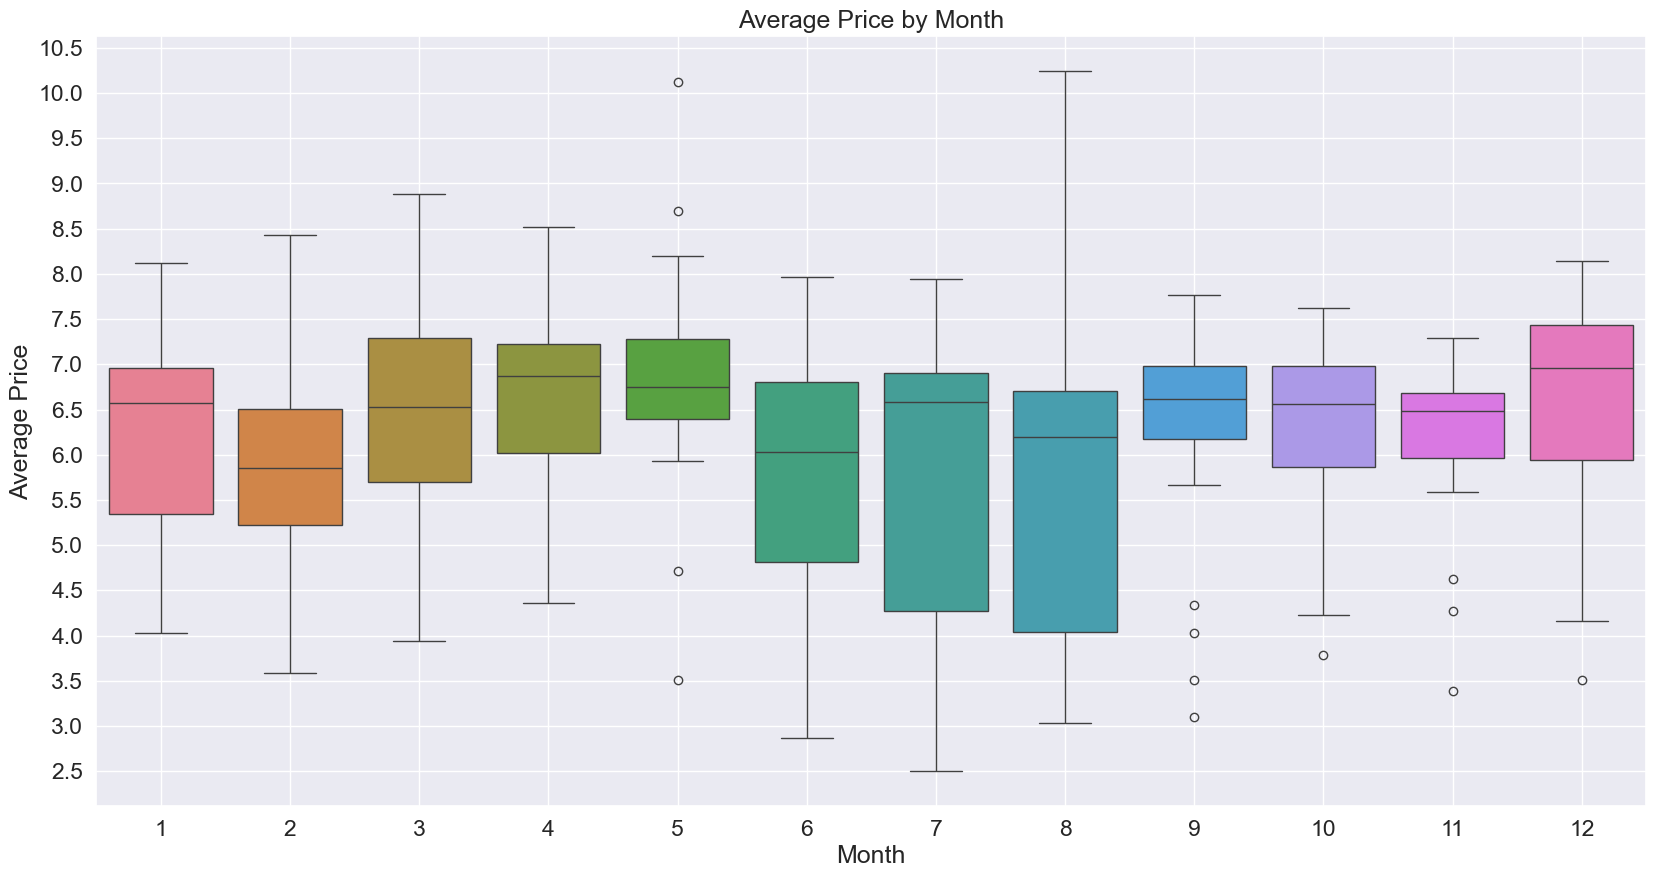

In [10]:

fig, ax = plt.subplots(figsize=(20, 10))


sns.boxplot(data=byYearPivot,  ax=ax)


ax.set_title('Average Price by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Average Price')
ax.grid(True)
ax.yaxis.set_major_locator(MultipleLocator(0.5))

In [11]:
def min_max(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return min_val, max_val

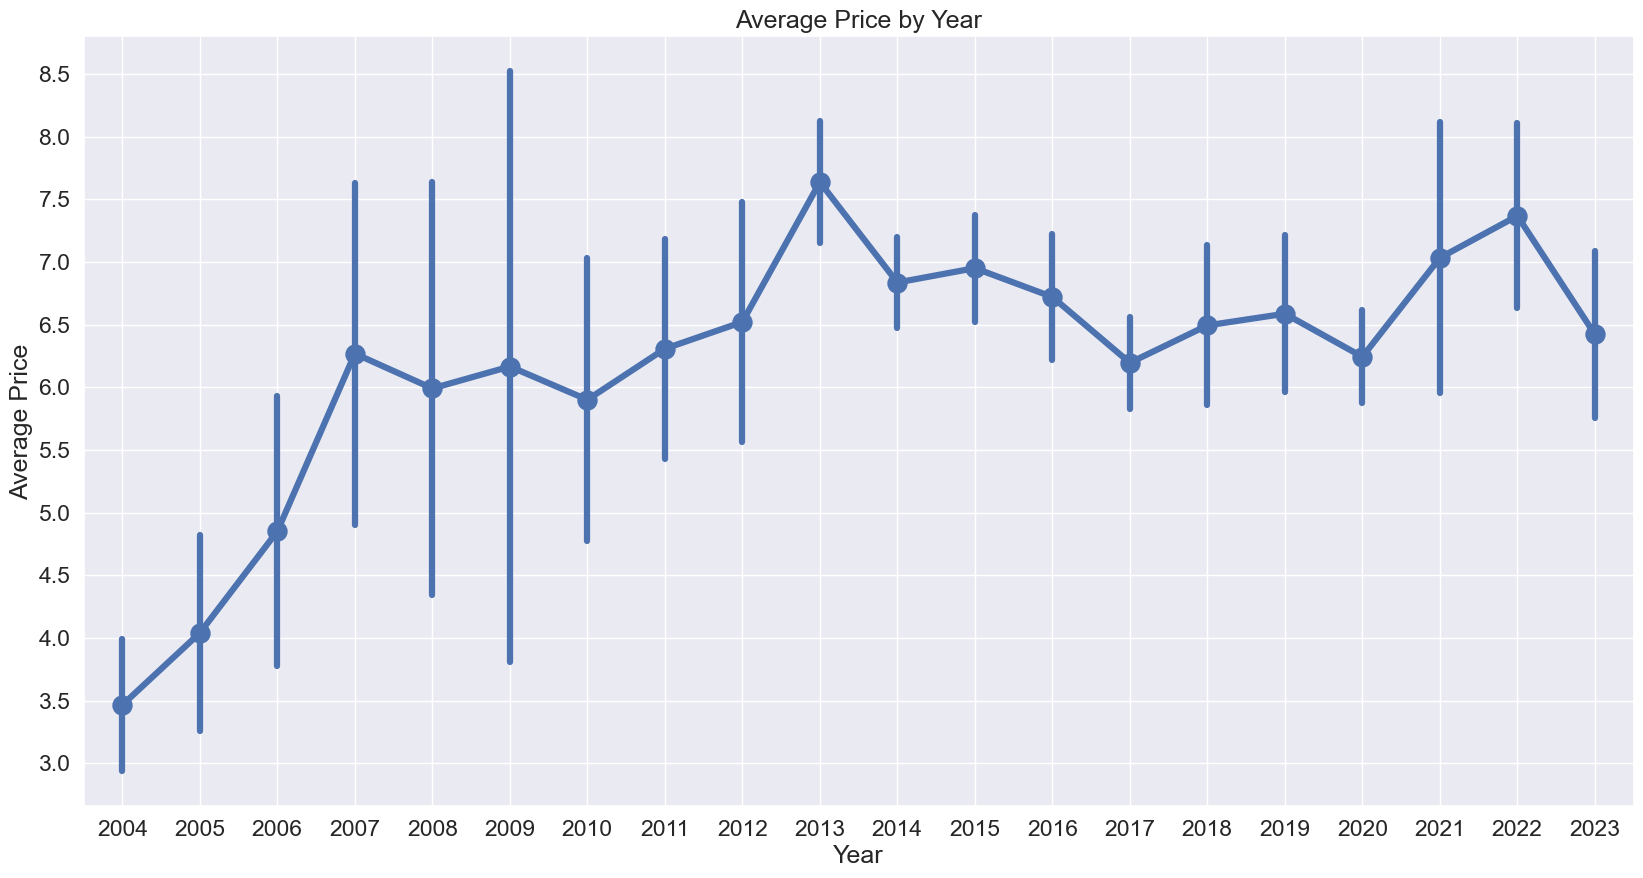

In [12]:

fig, ax = plt.subplots(figsize=(20, 10))


sns.pointplot(data=byMonthPivot,  ax=ax, errorbar='sd')


ax.set_title('Average Price by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Average Price')
ax.grid(True)
ax.yaxis.set_major_locator(MultipleLocator(0.5))

/Users/mikey/miniconda3/envs/ds5110_env/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mikey/miniconda3/envs/ds5110_env/lib/python3.12/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/mikey/miniconda3/envs/ds5110_env/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mikey/miniconda3/envs/ds5110_env/lib/python3.12/site-packag

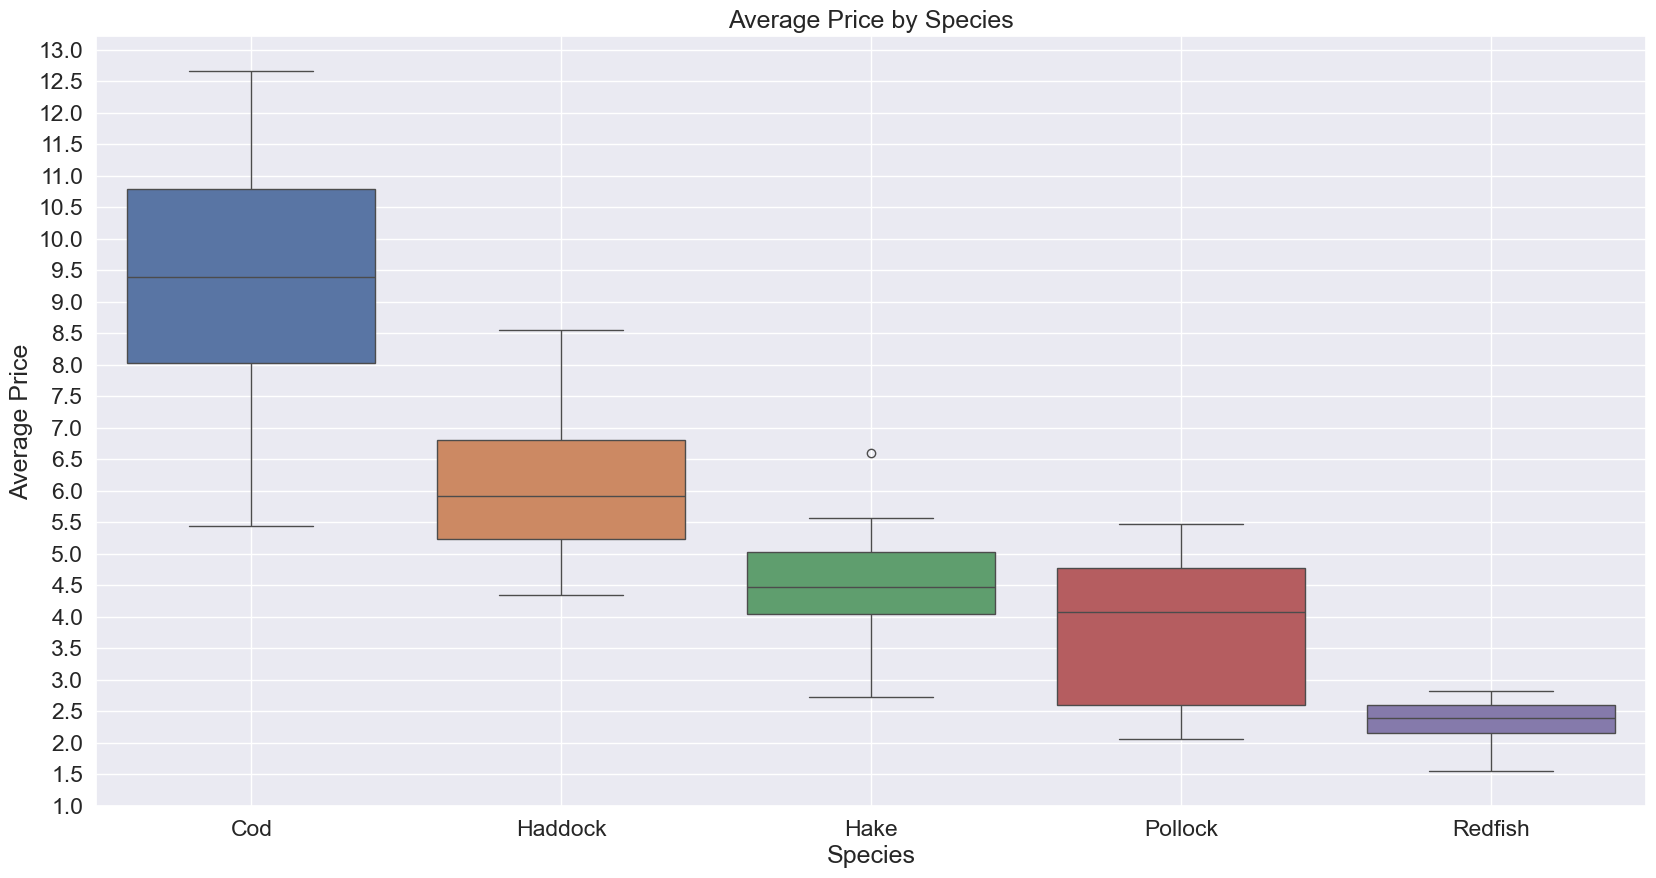

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))


sns.boxplot(data=bySpeciesPivot,  ax=ax)


ax.set_title('Average Price by Species')
ax.set_xlabel('Species')
ax.set_ylabel('Average Price')
ax.grid(True)
ax.yaxis.set_major_locator(MultipleLocator(0.5))